/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/nguyen/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


bisect at  11
bisect at  28
bisect at  33
bisect at  87
bisect at  748
end loop 999
residual end points [0.006043171240300062, 0.006039582115791743, 0.006035999422913937, 0.006032423293266352]
w = 1 m = 2     mu = 0.000625      residual = 0.006028853852900211
reconstructed gamma 0.03019384455769424      error_gamma 0.006461485256474669
error_omega 0.006775418448114218
grid = 100    noise = 0   tau = 1.03    loop =  999    run time = 2.9922282695770264


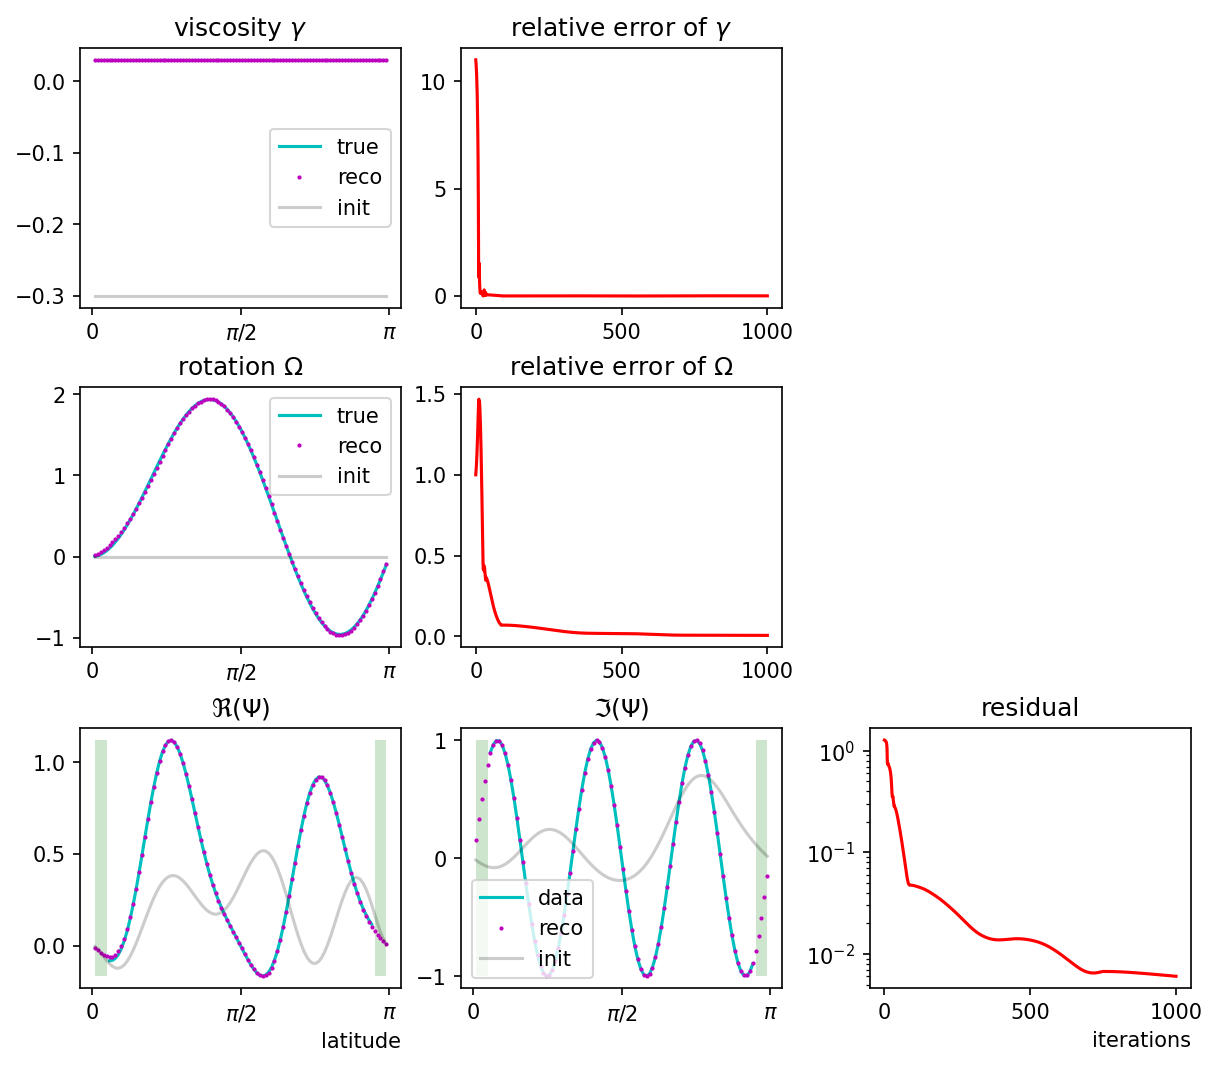

In [1]:
import numpy as np
import time
import copy
import pickle
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import sympy as sym

from inertial_functions import *

np.random.seed(311)
pi=np.pi
########################################################################
############################### INPUT. Enter your setup! ###############
########################################################################

#### Discretization

nx = 100               # grid point for omega, nx NOT includes boundaries odd number and is odd number

#### Equation: unknown parameters: rotation function omega, scalar viscosity

r   = 1                # radius of the Sun
w,m = (1,2)            # frequency w, longitude wave number; EX1 (3,3), EX2 (1,2)


omega_ref = 2          # omega_ref = Carrington_frame - boundary of omega_ext => reconstruct omega with zero boundary
  
#### Data: noise and leakage at poles, in percent

noise_level     = 0        
leak_level_real, leak_level_imag = (10,10)    

### Iterative reconstruction. Change if rescaled PDE!

loop = 1000              # max loops

tau =  1.03              # Discrepancy principle if run with noise. Actually nicer if stop at smaller tau=1.01

mu = 0.02               # important! step size for both
mu_scale_omega = 300    # important! adjust different stepsizes for omega = mu*mu_scale_omega



#######################################################################################################
################################### Symbolic simulation data ##########################################
#######################################################################################################

omin,omax = (0,pi);  dx = (omax-omin)/(nx+1); x = np.array(np.linspace(omin+dx,omax-dx,nx))  # discretize lattitude
sin,sin2x,cos,cos2x = (np.sin(x),np.sin(2*x),np.cos(x),np.cos(2*x))

s = sym.Symbol('s');       fsin = sym.sin(s)

### Input any analytic funtion fphi, fomega. We will compute the corespond source. 
# EX 1: Neumann boundary rotation
fphi      = -sym.sin(2*s)**4 + 1j*sym.sin(4*s) + 0.1*sym.sin(2*s) -0.2*sym.sin(4*s) # exact state

gamma_ext = 0.03                                                                    # exact viscosity

fomega    = sym.cos(3*s)+sym.cos(s)+ 0.5*sym.cos(2*s)**2;   boundary = 'Neumann'     # exact omega, Neumann bc

#'''
# EX 2: Dirichlet boundary rotation
fphi  = sym.sin(2*s)**4 + 1j*sym.sin(6*s) + 0.1*sym.sin(2*s)  -0.2*sym.sin(4*s)   #production for linear data, test noise

fomega    = (sym.sin(2*s)+sym.sin(s))*s;                 boundary = 'Dirichlet'   # exact omega, Diriclet bc
#fomega = 0.5*(sym.sin(2*s)  - 0.2*sym.sin(2*s)**2  + sym.sin(s) )*sym.cos(s)*2;   boundary = 'Dirichlet' 
#'''

### Symbolic compute components of PDE to derive source term

fbeta  = fomega - omega_ref                                                     # computed  beta
falpha  = 1/(r**2*fsin)*sym.diff(1/fsin*sym.diff(fsin**2*fomega,s),s)           # computed  alpha

flap    = 1/(r**2*fsin)*( sym.diff(fsin*sym.diff(fphi,s),s)-m**2*fphi/fsin )
fbi_lap = 1/(r**2*fsin)*( sym.diff(fsin*sym.diff(flap,s),s)-m**2*flap/fsin )

fsource = -gamma_ext*fbi_lap + -1j*w*flap + 1j*m*(fbeta*flap - falpha*fphi)     # computed exact source
                                    

### evaluate symbolic functions on grids x
omega_ext = sym.lambdify(s, fomega, "numpy");   omega_ext = omega_ext(x)   
phi_ext   = sym.lambdify(s, fphi,   "numpy");   phi_ext   = phi_ext(x)

source    = sym.lambdify(s, fsource,"numpy");   source    = source(x)

covf      = np.outer(source,source.conj())      # source covariance. Ignore cov from now on if you don't work with cov data

### If you have your example, just overwrite here, forget symbolic simulation above!
### gamma_exact, omega_ext are just to compare with the reconstruction, later in plotting
### phi_ext is needed for data, and source term is needed for the equation 
# gamma_ext = 
# omega_ext = 
# phi_ext   = 
# source    = 

##########################################################################
############################# MAIN PROGRAM ###############################
##########################################################################

kwargs = {"x": x, "dx": dx, "nx": nx, "r": r, \
          "leak_level_real": leak_level_real, "leak_level_imag": leak_level_imag, \
          "w": w, "m": m, "omega_ref": omega_ref}

# Inititate class
FD = FiniteDifferenceSphereFourierlong(**kwargs)
PDE = PartialDiffEq(FD = FD, source = source, **kwargs)
Data = GenerateData(PDE = PDE, data = phi_ext, noise_level = noise_level)

# Generate data from phi_ext
data     = Data.Observe(data_type = 'direct', noise_type = 'noisy')      # options: 'direct' or 'cov', 'noisy' or 'clean' 
data_ext = Data.Observe(data_type = 'direct', noise_type = 'clean')
data_dim = data.ndim

############################### Initial guess to start iteration #############################

# Set zero initial guesses. Change if you like!

gamma = gamma_ext*(-10)      
omega = omega_ext*0

PDE.Update(data = data, w = w, m = m, gamma = gamma, omega = omega)        # update class with initial parameters

# Set previous step, as Nesterov needs 2 previous steps
gamma_prev,omega_prev              = (gamma,omega)
gamma_init, omega_init, state_init = (gamma,omega,PDE.State)

cov_init = np.outer(state_init,state_init.conj())    # again, just ignore if you don't work with cov data

# Compute initial relative errors
residual = [PDE.Norm(PDE.Residual)]
gam_percent, omega_percent = (1/np.absolute(gamma_ext), 1/PDE.Norm(omega_ext))  
error_gamma, error_omega   = ([np.absolute(gamma-gamma_ext)*gam_percent], [PDE.Norm(omega-omega_ext)*omega_percent])


############################### Run Iteration #############################

stepsize = [mu]          # save all stepsize at each iterate, as it might be bisected, doubled
kcount   = 0             # count actual number of iterations

discrepancy = tau*PDE.Norm(data-data_ext)

start = time.time()
for k in range(loop):      
   
    ### compute intermetidate points z_k = x_k + lambda_k(x_k - x_{k-1}) in Nesterov-Landweber    
    lamda = k/(k+3)
    
    gamma_inter, omega_inter = (gamma + lamda*(gamma-gamma_prev), omega + lamda*(omega-omega_prev))
    
    ### save x_k serving x_{k-1} for next iteration   
    
    gamma_prev, omega_prev = (gamma,omega)

    ### Update classes at intermetidate points    
    
    PDE.Update(data = data, w = w, m = m, gamma = gamma_inter, omega = omega_inter)
    
    ### Compute adjoints at intermetidate points
    # Reconstructed omega in H2 with Neumann boundary other options: L2, H1, Dirichlet
    
    gamma_stride,omega_stride = PDE.Adjoint(space='H2', boundary=boundary,data_dim = data_dim)
    
    ### update parameter of interest
    
    gamma = gamma_inter - mu*gamma_stride
    omega = omega_inter - mu*omega_stride*mu_scale_omega           # adjust stepsize for omega

    ### compute errors
    PDE.Update(data = data, w = w, m = m, gamma = gamma, omega = omega)
    
    residual.append(PDE.Norm(PDE.Residual))   
    error_gamma.append(np.absolute(gamma-gamma_ext)*gam_percent)
    error_omega.append(PDE.Norm(omega-omega_ext)*omega_percent)

    ### two-way backtracking: bisect/double step_size mu if residual increases/decreases
    if (residual[-1] > 1.002*residual[-2]):               
        gamma,omega = (gamma_prev,omega_prev)
        mu = mu/2
        kcount -=1
        print('bisect at ',k)
    if (15*residual[-1] < residual[-2]):
        gamma,omega = (gamma_prev,omega_prev)
        mu = mu*2
        kcount -=1
    if (residual[-1]<8e-7) or (mu<1e-5) or (residual[-1]<discrepancy):  # terminate acc. discrepancy 
        break
     
    kcount +=1
    stepsize.append(mu)
    

end = time.time()


##########################################################################
############################## END PROGRAM ###############################
##########################################################################

printresult = PrintResult(data_ext = data_ext, data = data, \
                          omega_ext = omega_ext, gamma_ext = gamma_ext, source = source, **kwargs)
printresult.PrintLinear(gamma      = gamma,      omega      = omega,      state      = PDE.State, \
                        gamma_init = gamma_init, omega_init = omega_init, state_init = state_init, \
                        residual = residual, error_gamma = error_gamma, error_omega = error_omega)
print('end loop',k)
print('residual end points',residual[-5:-1])
print('w =',w, 'm =',m,'    mu =',mu,'     residual =',residual[-1])
print('reconstructed gamma',gamma,'     error_gamma',error_gamma[-1]);   
print('error_omega',error_omega[-1])
print('grid =',nx,'   noise =',noise_level,'  tau =',tau,'   loop = ',k,'   run time =', end-start)


